In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess
from Bio import Phylo
from io import StringIO
import msprime

## Theory: Pairwise

In [2]:
def effective_pop_size_pairwise(t1, t2, N, Ud, s):
    # t1 and t2 can be vectors
    
    t1 = np.maximum(t1, -1)
    t2 = np.maximum(t2, -1)
    
    prob_coal = 1/N * np.exp(Ud/s * (1 - np.exp(-s * t1)) * (1 - np.exp(-s * t2)))
    
    # support negative times
    Ne = np.where((t1 >= 0) & (t2 >= 0), 1/prob_coal, np.nan)
    
    return Ne

# Theory: All

In [3]:

def effective_pop_size_all(times, N, Ud, s):
    n_timepoints, n_lineages = times.shape
    n_lineage_pairs = int(scipy.special.binom(n_lineages, 2))
    
    all_prob_coals = np.zeros((n_timepoints, n_lineage_pairs))
    
    for k, (i,j) in enumerate(itertools.combinations(range(n_lineages), 2)):
        all_prob_coals[:, k] = 1 / effective_pop_size_pairwise(times[:,i], times[:,j], N, Ud, s)
        
    prob_coal = np.nansum(all_prob_coals, axis=1)
    n_live_lineages = (times >= 0).astype(int).sum(axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        Ne = np.where(prob_coal > 0, 1 / prob_coal * scipy.special.binom(n_live_lineages, 2), np.nan)
    
    return all_prob_coals, prob_coal, n_live_lineages, scipy.special.binom(n_live_lineages, 2), Ne
    

(0.0, 10432.332357823241)

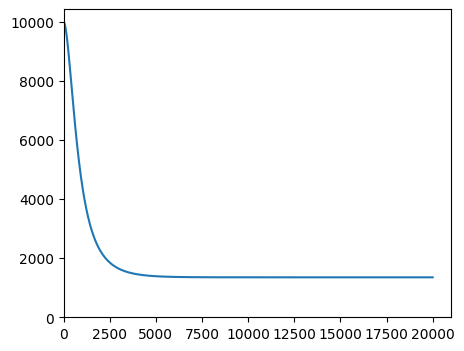

In [37]:
N = 1e4
s = 1e-3
Ud = s * 2

times = np.tile(np.arange(0, 20000), (5, 1)).T

all_prob_coals, prob_coal, n_live_lineages, n_live_lineages_pairs, Ne = effective_pop_size_all(times, N, Ud, s)

plt.figure(figsize=(5,4))
plt.plot(Ne)
plt.xlim(0, None)
plt.ylim(0, None)

Text(0, 0.5, '$N_e(t)$')

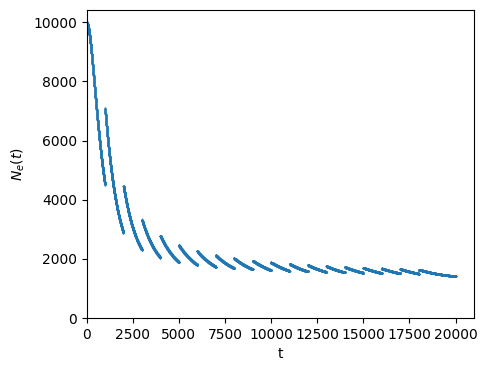

In [265]:
N = 1e4
s = 1e-3
Ud = s * 2

times = np.tile(np.arange(0, 20000), (20, 1)).T
tip_ages = np.concatenate([[0], np.arange(19)*1000])
for i in range(20):    
    times[:,i] -= tip_ages[i]

all_prob_coals, prob_coal, n_live_lineages, n_live_lineages_pairs, Ne = effective_pop_size_all(times, N, Ud, s)

plt.figure(figsize=(5,4))
plt.plot(Ne, '.', ms=0.5)
plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("t")
plt.ylabel("$N_e(t)$")
#plt.axhline(40000, color="black")
#plt.axvline(5000, color="black")

array([[     0,      0,  -1000, ..., -16000, -17000, -18000],
       [     1,      1,   -999, ..., -15999, -16999, -17999],
       [     2,      2,   -998, ..., -15998, -16998, -17998],
       ...,
       [ 19997,  19997,  18997, ...,   3997,   2997,   1997],
       [ 19998,  19998,  18998, ...,   3998,   2998,   1998],
       [ 19999,  19999,  18999, ...,   3999,   2999,   1999]])

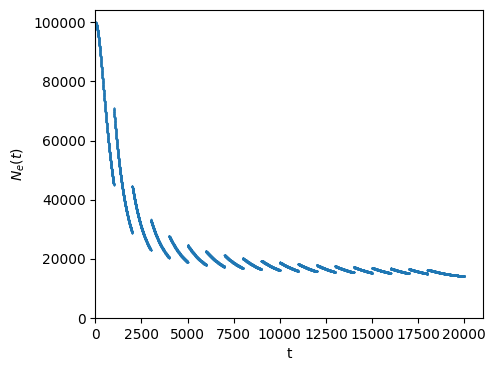

In [43]:
N = 1e5
s = 1e-3
Ud = s * 2

# Make this one ten at 0 and ten at 10000 (to do)

times = np.tile(np.arange(0, 20000), (20, 1)).T
tip_ages = np.concatenate([[0], np.arange(19)*1000])
for i in range(20):    
    times[:,i] -= tip_ages[i]

all_prob_coals, prob_coal, n_live_lineages, n_live_lineages_pairs, Ne = effective_pop_size_all(times, N, Ud, s)

plt.figure(figsize=(5,4))
plt.plot(Ne, '.', ms=0.5)
plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("t")
plt.ylabel("$N_e(t)$")


## Slim

In [444]:
# Process slim output into a tree and mutations

slimoutputfile = "pytest.trees"

def extract_tree_sequence(slimoutputfile,sample_times,sample_sizes,add_neutral=False):
    
    num_times = len(sample_times)
    if num_times!=len(sample_sizes): print("Please give the same length list for sample times and sizes.")
    
    tree = tskit.load(slimoutputfile) 

    # Subsample tree
    sample = [np.random.choice(pyslim.individuals_alive_at(tree,sample_times[i]), 
                               size = int(sample_sizes[i]), replace=False) for i in list(range(num_times))]
    sample = np.concatenate(sample)
    sample_nodes = [tree.individual(i).nodes[0] for i in sample]
    # Identifying the nodes of the chosen downsample individuals. 
    ts_ds = tree.simplify(samples=sample_nodes) 
    # This writes a new tree sequence with just downsampled individuals.
    
    # Add neutral mutations if needed
    if add_neutral:
        next_id = pyslim.next_slim_mutation_id(ts_ds)
        ts = msprime.sim_mutations(
               ts_haploid,
               rate=1e-3,    # per bp
               model=msprime.SLiMMutationModel(type=3, next_id=next_id), # type=3 is just any mutation type unused in the simulation
               keep=True)
        print(f"We have {ts_ds.num_mutations} deleterious mutations and {tsn.num_mutations} total mutations.")
    else:
        ts = ts_ds
    
    # Get coalescent times.
    node_times = ts.tables.nodes.time
    coal_times = node_times[sum(sample_sizes):] # the first ones are tips, so a bunch of 0s
    
    # Get mutation information.
    mutation_times = []
    mutation_edges = []
    for m in ts.mutations():
        mutation_times.append(m.metadata["mutation_list"][0]["slim_time"])
        mutation_edges.append(m.edge)
    
    # Double check everyone has coalesced within the time frame.
    tsf = ts.first()
    if len(tsf.roots) != 1 : print("Problem: Not everyone has coalesced within your time frame! need to recapitate")
        # (add recapitation in if it ever happens)

    return ts, coal_times, mutation_times, mutation_edges

ts, coal_times, mutation_times, mutation_edges = extract_tree_sequence(output,sample_times=[0,10000],sample_sizes=[10,10])

print(coal_times)
print(mutation_times)
print(mutation_edges)


[7.0000e+00 1.0000e+01 4.8000e+01 6.7000e+01 1.4100e+02 2.1000e+02
 2.3300e+02 3.6900e+02 4.3300e+02 1.0031e+04 1.0061e+04 1.0088e+04
 1.0091e+04 1.0186e+04 1.0251e+04 1.0307e+04 1.0517e+04 1.0887e+04
 1.3187e+04]
[14549, 9742, 9521, 9822, 500, 14965, 18177, 9908, 9712, 9826, 8266, 13430, 8151, 8180, 9165, 16920, 2415, 7362, 15822, 8159, 1920, 4190, 6494, 14723]
[25, 31, 33, 27, -1, 25, 25, 26, 30, 30, 37, 25, 37, 36, 36, 25, -1, 36, 25, 37, -1, -1, -1, 25]


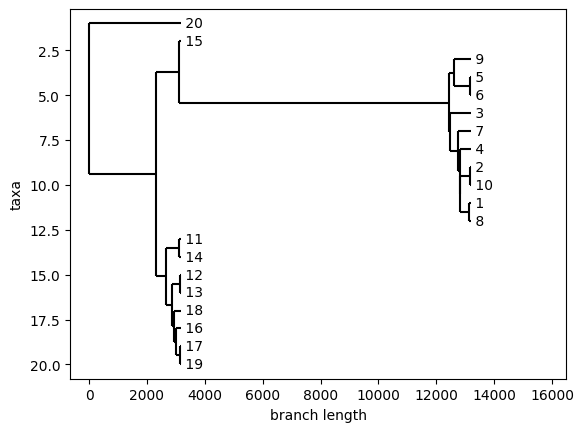

In [435]:
# Plot tree for sanity check
tree = ts.first()
newick = tree.newick()
tree = Phylo.read(StringIO(newick), "newick")
Phylo.draw(tree)

In [438]:
# What units are the branch lengths in? How do we get them in generations? 
# How do we get these coalescent times on a graph like the ones we have above?
# We need enough that we can turn them into a probability, right?#
 
# I'm thinking you'll want to run a load of simulations with the same parameters (like 1000 or 10000?) 
# and store them every 1000 generations. Then you can subsample them every scenario we've got here.
# Having enough of them will give us a "probability" instead of just a discrete sample. 